In [213]:
import pandas as pd               
import numpy as np 

import sklearn
from xgboost import XGBRegressor
import time
import pickle 
import warnings

from matplotlib import pyplot as plt
from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

warnings.filterwarnings('ignore')
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline




In [214]:
df = pd.read_csv('Traffic_Volume.csv')
na_counts = df.isna().sum()
print(na_counts)

df.head()

holiday           48143
temp                  0
rain_1h               0
snow_1h               0
clouds_all            0
weather_main          0
date_time             0
traffic_volume        0
dtype: int64


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,10/2/12 9:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,10/2/12 10:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,10/2/12 11:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,10/2/12 12:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,10/2/12 13:00,4918


In [215]:
# Convert 'date_time' to datetime format
df['date_time'] = pd.to_datetime(df['date_time'], format='%m/%d/%y %H:%M')

# Extract day, month, and year as integers
df['day'] = df['date_time'].dt.day.astype(int)
df['month'] = df['date_time'].dt.month.astype(int)
df['year'] = df['date_time'].dt.year.astype(int)

# Convert time to seconds since midnight
df['time'] = (df['date_time'].dt.hour)
# Drop the original 'date_time' column
df = df.drop(columns=['date_time'])

# Split into features and target
X = df.drop(columns='traffic_volume')  # Features
y = df['traffic_volume']               # Target

# One-hot encode categorical variables
cat_vars = ['holiday', 'weather_main']
X_encoded = pd.get_dummies(X, columns=cat_vars)

# Display the first few rows of the encoded DataFrame
display(df['time'])


0         9
1        10
2        11
3        12
4        13
         ..
48199    19
48200    20
48201    21
48202    22
48203    23
Name: time, Length: 48204, dtype: int32

In [216]:
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42)

In [217]:
'''xgb_model = XGBRegressor(random_state=0)

hyper_params = {'max_depth': [5, 10],
                'min_samples_split': [10, 20],
                'min_samples_leaf': [10, 20]}

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

model_cv = GridSearchCV(estimator = xgb_model,
                        param_grid = hyper_params,
                        scoring = 'r2',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1)
'''


"xgb_model = XGBRegressor(random_state=0)\n\nhyper_params = {'max_depth': [5, 10],\n                'min_samples_split': [10, 20],\n                'min_samples_leaf': [10, 20]}\n\nfolds = KFold(n_splits = 5, shuffle = True, random_state = 100)\n\nmodel_cv = GridSearchCV(estimator = xgb_model,\n                        param_grid = hyper_params,\n                        scoring = 'r2',\n                        cv = folds,\n                        verbose = 1,\n                        n_jobs = -1)\n"

In [218]:
'''start = time.time()           
model_cv.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

print('Initial score: ', model_cv.best_score_)
print('Initial parameters: ', model_cv.best_params_)'''

'start = time.time()           \nmodel_cv.fit(train_X, train_y)\nstop = time.time()             \nprint(f"Training time: {stop - start}s")\n\nprint(\'Initial score: \', model_cv.best_score_)\nprint(\'Initial parameters: \', model_cv.best_params_)'

In [219]:
'''best_xbg_model = model_cv.best_estimator_

y_pred_best_xbg_model = best_xbg_model.predict(test_X)'''

'best_xbg_model = model_cv.best_estimator_\n\ny_pred_best_xbg_model = best_xbg_model.predict(test_X)'

In [220]:
'''# Evaluate the model on test set
r2 = sklearn.metrics.r2_score(test_y, y_pred_best_xbg_model)
print('R-squared on Test Set: %0.2f' %r2)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, y_pred_best_xbg_model)
print('RMSE on Test Set: %0.2f' %RMSE_test)'''

"# Evaluate the model on test set\nr2 = sklearn.metrics.r2_score(test_y, y_pred_best_xbg_model)\nprint('R-squared on Test Set: %0.2f' %r2)\n\nRMSE_test = sklearn.metrics.root_mean_squared_error(test_y, y_pred_best_xbg_model)\nprint('RMSE on Test Set: %0.2f' %RMSE_test)"

In [221]:
'''# Calculate the residuals by subtracting the predicted values from the actual test values
all_residuals = test_y - y_pred_best_xbg_model

# Set up the figure with custom size and resolution (DPI)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot the histogram of residuals
plt.hist(all_residuals, bins = 25, color = 'blue', edgecolor = 'black')

# Label X and Y axes
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)

# Set the title of the plot
plt.title('Distribution of Residuals', fontsize = 16)

# Adjust the font size of x and y ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.savefig('distribution_plot.png')'''

"# Calculate the residuals by subtracting the predicted values from the actual test values\nall_residuals = test_y - y_pred_best_xbg_model\n\n# Set up the figure with custom size and resolution (DPI)\nplt.figure(figsize=(6, 4), dpi = 150)\n\n# Plot the histogram of residuals\nplt.hist(all_residuals, bins = 25, color = 'blue', edgecolor = 'black')\n\n# Label X and Y axes\nplt.xlabel('Residuals', fontsize = 14)\nplt.ylabel('# of Test Datapoints', fontsize = 14)\n\n# Set the title of the plot\nplt.title('Distribution of Residuals', fontsize = 16)\n\n# Adjust the font size of x and y ticks\nplt.xticks(fontsize = 10)\nplt.yticks(fontsize = 10)\nplt.savefig('distribution_plot.png')"

In [222]:
'''# Setting the figure size and resolution
plt.figure(figsize = (6, 4), dpi = 150)

# Scatter plot of actual vs predicted values
plt.scatter(test_y, y_pred_best_xbg_model, color = 'blue', alpha = 0.6, edgecolor = 'black', s = 40)

# 45-degree reference line (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)

# Axis labels and title
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)

# Adjust ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.savefig('scatter_plot.png')'''

"# Setting the figure size and resolution\nplt.figure(figsize = (6, 4), dpi = 150)\n\n# Scatter plot of actual vs predicted values\nplt.scatter(test_y, y_pred_best_xbg_model, color = 'blue', alpha = 0.6, edgecolor = 'black', s = 40)\n\n# 45-degree reference line (perfect predictions)\nplt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)\n\n# Axis labels and title\nplt.xlabel('Actual Values', fontsize = 10)\nplt.ylabel('Predicted Values', fontsize = 10)\nplt.title('Predicted vs Actual Values', fontsize = 12)\n\n# Adjust ticks\nplt.xticks(fontsize = 10)\nplt.yticks(fontsize = 10)\nplt.savefig('scatter_plot.png')"

In [223]:
'''# Storing importance values from the trained model
importance = best_xbg_model.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(8, 4))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['red', 'lime'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting admission chances?', fontsize = 12) 
plt.yticks(fontsize = 10) # fontsize of yticks
plt.xticks(fontsize = 10) # fontsize of xticks

plt.tight_layout()
plt.savefig('feature_imp.png')'''

'# Storing importance values from the trained model\nimportance = best_xbg_model.feature_importances_\n\n# Storing feature importance as a dataframe\nfeature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),\n               columns = [\'Feature\', \'Importance\'])\n\nfeature_imp = feature_imp.sort_values(\'Importance\', ascending = False).reset_index(drop = True)\n\n# Bar plot\nplt.figure(figsize=(8, 4))\nplt.barh(feature_imp[\'Feature\'], feature_imp[\'Importance\'], color = [\'red\', \'lime\'])\n\nplt.xlabel("Importance", fontsize = 12)\nplt.ylabel("Input Feature", fontsize = 12)\nplt.title(\'Which features are the most important for predicting admission chances?\', fontsize = 12) \nplt.yticks(fontsize = 10) # fontsize of yticks\nplt.xticks(fontsize = 10) # fontsize of xticks\n\nplt.tight_layout()\nplt.savefig(\'feature_imp.png\')'

In [224]:
'''# Creating the file where we want to write the model
xgb_pickle = open('xbg_traffic.pickle', 'wb') 

# Write RF model to the file
pickle.dump(best_xbg_model, xgb_pickle) 

# Close the file
xgb_pickle.close()'''

"# Creating the file where we want to write the model\nxgb_pickle = open('xbg_traffic.pickle', 'wb') \n\n# Write RF model to the file\npickle.dump(best_xbg_model, xgb_pickle) \n\n# Close the file\nxgb_pickle.close()"

In [225]:
import multiprocessing
total_cores = multiprocessing.cpu_count()

print(total_cores)

cores_used = total_cores // 2

10


In [226]:
xgb_model = XGBRegressor(random_state=0)

In [227]:
from xgboost import XGBRegressor
from mapie.regression import MapieRegressor
from sklearn.model_selection import GridSearchCV, KFold
import time

# Define the base XGBoost model
xgb_model = XGBRegressor(random_state=42)

# Wrap the base model with MapieRegressor
mapie = MapieRegressor(estimator=xgb_model, n_jobs=-1, random_state=42)

# Define hyperparameter grid for GridSearchCV
hyper_params = {
    'estimator__max_depth': [5, 8],       # Hyperparameters for XGBRegressor
    'estimator__n_estimators': [50, 100]
}

# Define cross-validation strategy
folds = KFold(n_splits=5, shuffle=True, random_state=100)

# Use GridSearchCV to find the best hyperparameters
model_cv = GridSearchCV(
    estimator=mapie,
    param_grid=hyper_params,
    scoring='r2',
    cv=folds,
    verbose=1,
    n_jobs=-1
)

# Fit the GridSearchCV
start = time.time()
model_cv.fit(train_X, train_y)
stop = time.time()

# Print training time
print(f"Training time: {stop - start}s")

# Display the best parameters and score
print("Best Parameters:", model_cv.best_params_)
print("Best Cross-Validation R2 Score:", model_cv.best_score_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training time: 40.75578212738037s
Best Parameters: {'estimator__max_depth': 8, 'estimator__n_estimators': 100}
Best Cross-Validation R2 Score: 0.8495896339416504


In [228]:
# Use the best estimator from GridSearchCV
best_mapie = model_cv.best_estimator_

# Set alpha for confidence interval (90% confidence level corresponds to alpha = 0.1)
alpha = 0.1

# Make predictions with confidence intervals
y_test_pred, y_test_pis = best_mapie.predict(test_X, alpha=alpha)
best_mapie = best_mapie.fit(train_X, train_y)

# Separate the lower and upper bounds
lower_bounds = y_test_pis[:, 0]
upper_bounds = y_test_pis[:, 1]

# Display predictions and confidence intervals
print("Predictions:", y_test_pred)
print("Lower Bounds:", lower_bounds)
print("Upper Bounds:", upper_bounds)


Predictions: [5596.1367  2570.8486   591.5982  ... 2392.3857  2362.525    690.87976]
Lower Bounds: [[4116.37548828]
 [1408.39550781]
 [-334.04455566]
 ...
 [1138.83398438]
 [1097.16601562]
 [-757.96084595]]
Upper Bounds: [[6777.00634766]
 [3778.28320312]
 [2036.77459717]
 ...
 [3490.4296875 ]
 [3471.04882812]
 [1618.43356323]]


In [235]:
# Evaluate the model on test set
r2 = sklearn.metrics.r2_score(test_y, y_test_pred)
print('R-squared on Test Set: %0.2f' %r2)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, y_test_pred)
print('RMSE on Test Set: %0.2f' %RMSE_test)

R-squared on Test Set: 0.86
RMSE on Test Set: 750.99


In [236]:
# Storing results in a dataframe
predictions = test_y.to_frame()
predictions.columns = ['Actual Value']
predictions["Predicted Value"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions.tail(5)

,Actual Value,Predicted Value,Lower Value,Upper Value
6401,2491,1351.180054,767.38,3303.72
34004,5251,4205.020020,3001.30,5527.26
46086,2224,2392.389893,1138.83,3490.43
42579,2928,2362.520020,1097.17,3471.05
23709,910,690.880005,-757.96,1618.43


In [231]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 92.38%


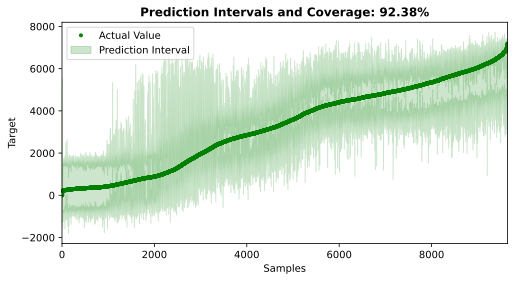

In [232]:
# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Value"], 'go', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="green", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10)
plt.savefig('prediction_interval_coverage.png')

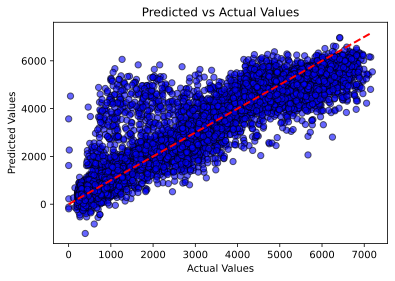

In [233]:
# Setting the figure size and resolution
plt.figure(figsize = (6, 4), dpi = 150)

# Scatter plot of actual vs predicted values
plt.scatter(test_y, y_test_pred, color = 'blue', alpha = 0.6, edgecolor = 'black', s = 40)

# 45-degree reference line (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)

# Axis labels and title
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)

# Adjust ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.savefig('scatter_plot.png')

In [234]:
# Access feature importances from the best XGBoost model
importance = best_mapie.estimator.feature_importances_

# Create a DataFrame with feature names and their importance
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)), 
                           columns=['Feature', 'Importance'])

# Sort features by importance in descending order
feature_imp = feature_imp.sort_values('Importance', ascending=False).reset_index(drop=True)

# Bar plot
plt.figure(figsize=(8, 6))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color='skyblue')
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Input Feature", fontsize=12)
plt.title('Feature Importance for Predicting Traffic Volume', fontsize=14) 
plt.yticks(fontsize=10)  # fontsize of yticks
plt.xticks(fontsize=10)  # fontsize of xticks

plt.tight_layout()
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.savefig('feature_imp.png')
plt.show()


NotFittedError: need to call fit or load_model beforehand

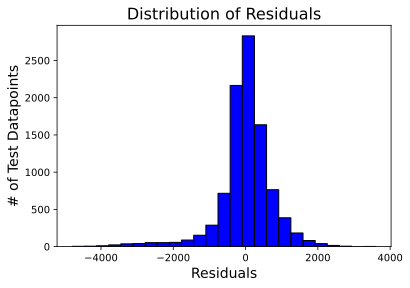

In [237]:
# Calculate the residuals by subtracting the predicted values from the actual test values
all_residuals = test_y - y_test_pred

# Set up the figure with custom size and resolution (DPI)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot the histogram of residuals
plt.hist(all_residuals, bins = 25, color = 'blue', edgecolor = 'black')

# Label X and Y axes
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)

# Set the title of the plot
plt.title('Distribution of Residuals', fontsize = 16)

# Adjust the font size of x and y ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.savefig('distribution_plot.png')

In [239]:
# Creating the file where we want to write the model
reg_pickle = open('mapie_traffic.pickle', 'wb') 

# Write RF model to the file
pickle.dump(mapie, reg_pickle) 

# Close the file
reg_pickle.close()